# 0.0 IMPORTS

In [29]:
import pandas                                          as pd
import inflection
import math
import numpy                                           as np
import seaborn                                         as sns
import matplotlib.pyplot                               as plt
import matplotlib.gridspec                             as gridspec

import datetime              
from tabulate              import tabulate
from scipy.stats           import chi2_contingency
from IPython.display       import Image
from IPython.core.display  import HTML

from scipy                 import stats                as ss
from geopy.geocoders       import Nominatim
#from geopy.distance        import geodesic
import holidays

## 0.1 Helper Function

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [47]:
df_trip_2010_raw = pd.read_csv('data/2010_tripdata.csv', low_memory=False)
df_trip_2011_raw = pd.read_csv('data/2011_tripdata.csv', low_memory=False)
df_trip_raw = pd.concat( [df_trip_2010_raw, df_trip_2011_raw] )

In [48]:
df_trip_raw.sample(5)

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
165807,7005,2011-04-07 18:51:24,2011-04-07 20:48:09,31236,37th & O St NW / Georgetown University,31225,C & O Canal & Wisconsin Ave NW,W00707,Casual
1200962,627,2011-12-20 04:54:47,2011-12-20 05:05:15,31618,4th & East Capitol St NE,31219,10th St & Constitution Ave NW,W01000,Member
1951,897,2010-09-25 14:25:16,2010-09-25 14:40:14,31206,19th & E Street NW,31206,19th & E Street NW,W00918,Casual
612092,1146,2011-07-20 20:10:25,2011-07-20 20:29:31,31112,Harvard St & Adams Mill Rd NW,31203,14th & Rhode Island Ave NW,W00128,Member
91922,159,2010-12-04 14:07:04,2010-12-04 14:09:43,31620,5th & F St NW,31228,8th & H St NW,W00538,Member


# 1.0 - DESCRIPTION OF DATA

In [49]:
df1 = df_trip_raw.copy()

## 1.1 Rename Columns

In [50]:
df1.columns
# I like to modify the column names in order to change all of them in lower case and underline between words. At the same time, names must be self-explanatory.

Index(['Duration', 'Start date', 'End date', 'Start station number',
       'Start station', 'End station number', 'End station', 'Bike number',
       'Member type'],
      dtype='object')

In [51]:
cols_old = ['Duration', 'Start date', 'End date', 'Start station number', 'Start station', 'End station number', 'End station', 'Bike number', 'Member type']
cols_old_ajusted = ['Duration', 'StartDate', 'EndDate', 'StartStationNumber', 'StartStation', 'EndStationNumber', 'EndStation', 'BikeNumber', 'MemberType']

# Whats is snakecase?
# Whats do inflection.underscore function?
snakecase = lambda x: inflection.underscore( x )

# Why I use lis?
cols_new = list( map( snakecase, cols_old_ajusted ) )

# rename
df1.columns = cols_new

In [52]:
# I will add the "index" column to help me in dealing with some techniques of managing data like check unbalanced data.
df1.insert(loc=0, column='id', value=df1.index)

In [53]:
df1.columns

Index(['id', 'duration', 'start_date', 'end_date', 'start_station_number',
       'start_station', 'end_station_number', 'end_station', 'bike_number',
       'member_type'],
      dtype='object')

## 1.2 Data Dimensions

In [54]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 1342364
Number of Cols: 10


## 1.3 Data Types

In [55]:
df1.dtypes
# Observe date. It has a different data type.
# I will want to change the "id" from int to category

id                       int64
duration                 int64
start_date              object
end_date                object
start_station_number     int64
start_station           object
end_station_number       int64
end_station             object
bike_number             object
member_type             object
dtype: object

In [56]:
df1['start_date'] = pd.to_datetime( df1['start_date'] )
df1['end_date'] = pd.to_datetime( df1['end_date'] )

df1['id'] = df1['id'].apply( lambda x: str(x) )

In [57]:
df1.dtypes

id                              object
duration                         int64
start_date              datetime64[ns]
end_date                datetime64[ns]
start_station_number             int64
start_station                   object
end_station_number               int64
end_station                     object
bike_number                     object
member_type                     object
dtype: object

## 1.4 Check NA

In [58]:
df1.isna().sum()

id                      0
duration                0
start_date              0
end_date                0
start_station_number    0
start_station           0
end_station_number      0
end_station             0
bike_number             0
member_type             0
dtype: int64

## 1.5 Fillout NA

In [59]:
# There aren't NaN values to fill.

## 1.6 Check Unbalanced Data

In [60]:
df_balanced = df1[['id', 'member_type']].groupby( 'member_type' ).count().sort_values( 'id' ).reset_index()
df_balanced['perc%'] = 100*np.round( ( df_balanced['id'] / np.sum( df_balanced['id'] ) ), 4 )
df_balanced

,member_type,id,perc%
0,Unknown,14,0.00
1,Casual,270950,20.18
2,Member,1071400,79.81


## 1.7 Descriptive Analysis

### 1.7.1 General

In [61]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

#### 1.7.1.1 Numerical

In [62]:
# Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,duration,60.0,86355.0,86295.0,1186.020292,681.0,2516.315042,14.677102,341.051419
1,start_station_number,31000.0,31806.0,806.0,31285.376381,31219.0,192.947598,0.822809,-0.693047
2,end_station_number,31000.0,31806.0,806.0,31286.714433,31219.0,192.034328,0.840482,-0.665674


#### 1.7.1.2 Categorical

In [63]:
cat_attributes.drop( 'id', axis=1 ).describe()

,start_station,end_station,bike_number,member_type
count,1342364,1342364,1342364,1342364
unique,144,144,1341,3
top,Massachusetts Ave & Dupont Circle NW,Massachusetts Ave & Dupont Circle NW,W00856,Member
freq,54186,59513,1755,1071400


### 1.7.2 Classes Oriented

#### 1.7.2.1 Numerical

In [64]:
aux = df1[['duration', 'start_station_number', 'end_station_number', 'member_type']].groupby( 'member_type' ).agg( 
        duration_min      = ('duration', 'min'), 
        duration_max      = ('duration', 'max'),
        duration_mean     = ('duration', 'mean'),
        duration_median   = ('duration', 'median'),
        duration_range    = ('duration', lambda x: x.max() - x.min() ),
        duration_skew     = ('duration', lambda x: x.skew() ),
        duration_kurtosis = ( 'duration', lambda x: x.kurtosis() ),
        start_station_number_min    =   ('start_station_number', 'min'), 
        start_station_number_max    =   ('start_station_number', 'max'),
        start_station_number_mean   =   ('start_station_number', 'mean'),
        start_station_number_median =   ('start_station_number', 'median'),
        start_station_number_range  =   ('start_station_number', lambda x: x.max() - x.min() ),
        start_station_number_skew   =   ('start_station_number', lambda x: x.skew() ),
        start_station_number_kurtosis = ( 'start_station_number', lambda x: x.kurtosis() ),
        end_station_numberr_min    =   ('end_station_number', 'min'), 
        end_station_number_max    =   ('end_station_number', 'max'),
        end_station_number_mean   =   ('end_station_number', 'mean'),
        end_station_number_median =   ('end_station_number', 'median'),
        end_station_number_range  =   ('end_station_number', lambda x: x.max() - x.min() ),
        end_station_number_skew   =   ('end_station_number', lambda x: x.skew() ),
        end_station_number_kurtosis = ( 'end_station_number', lambda x: x.kurtosis() ) )

# show table
aux

,duration_min,duration_max,duration_mean,duration_median,duration_range,duration_skew,duration_kurtosis,start_station_number_min,start_station_number_max,start_station_number_mean,start_station_number_median,start_station_number_range,start_station_number_skew,start_station_number_kurtosis,end_station_numberr_min,end_station_number_max,end_station_number_mean,end_station_number_median,end_station_number_range,end_station_number_skew,end_station_number_kurtosis
member_type,,,,,,,,,,,,,,,,,,,,,
Casual,61,86337,2818.136125,1451,86276,8.078695,108.375829,31000,31806,31271.451187,31220.0,806,1.061437,0.081252,31000,31805,31271.944971,31219,805,1.088322,0.127234
Member,60,86355,773.274534,596,86295,29.857263,1178.366262,31000,31806,31288.898870,31219.0,806,0.768298,-0.838357,31000,31806,31290.451235,31219,806,0.783851,-0.814061
Unknown,168,2477,758.857143,413,2309,1.602714,1.460630,31010,31620,31216.571429,31216.5,610,1.161179,1.214685,31003,31302,31156.428571,31209,299,-0.613007,-1.316036


#### 1.7.2.2 Categorical

In [65]:
cat_attributes.drop( 'id', axis=1 ).groupby( 'member_type' ).describe()

start_station                                                     end_station                                                     bike_number                     
                    count unique                                   top   freq       count unique                                   top   freq       count unique     top  freq
member_type                                                                                                                                                                   
Casual             270950    140  Massachusetts Ave & Dupont Circle NW  12104      270950    139     USDA / 12th & Independence Ave SW  14632      270950   1332  W00726   371
Member            1071400    143  Massachusetts Ave & Dupont Circle NW  42082     1071400    144  Massachusetts Ave & Dupont Circle NW  46959     1071400   1340  W00893  1432
Unknown                14     10                     23rd & Crystal Dr      3          14     12   Crystal City Metro / 18th & Bell St      2          14     14  W01070     1

### 1.7.3 Predictors and Class Correlation

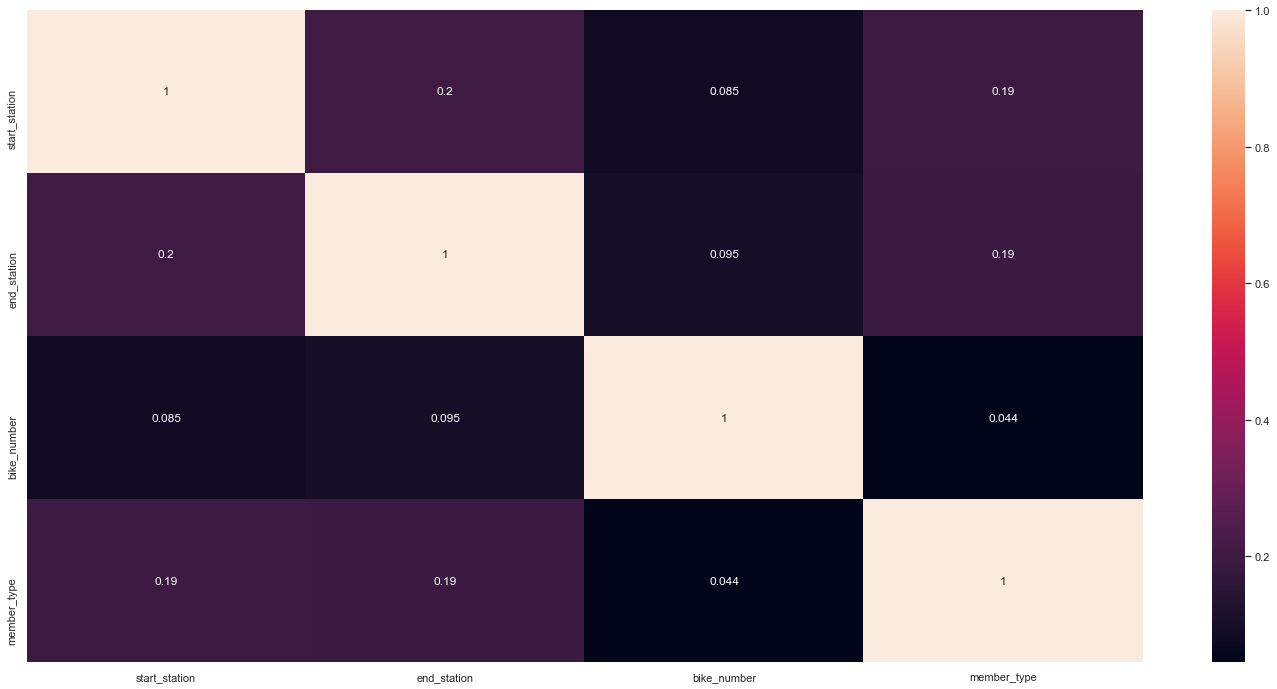

In [66]:
# list of categorical attributes
cat_attributes_list = cat_attributes.drop( 'id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        #print( 'Ref: {} - Feat: {}'.format( cat_attributes_list[i], cat_attributes_list[j] ) )
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation between two categorical variables
        corr = cramer_v( cat_attributes[ ref ], cat_attributes[ feat ] )
        
        # append to a list
        corr_list.append( corr )
        
    # append the correlation list for each ref attributes
    corr_dict[ref] = corr_list

d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 2.0 FEATURE ENGINEERING

In [67]:
df2 = df1.copy()

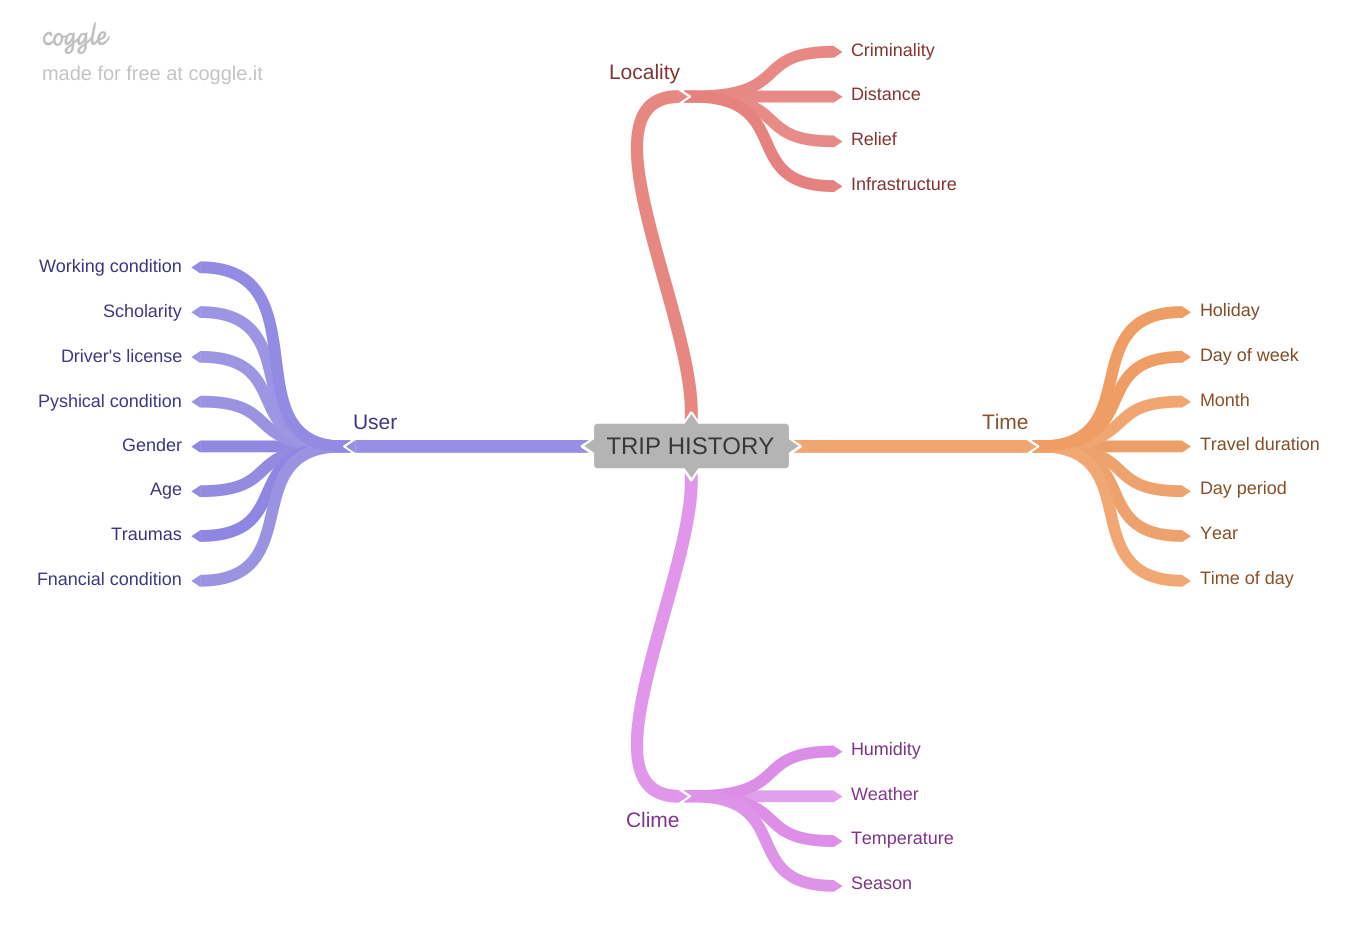

In [68]:
Image( "image/Hyphoteses_Map.png")

## 2.1 Creation of Hypotheses

### 2.1.1 Locality Hyphoteses

**1.** Casual users should be in places with higher crime.

**2.** Member users must travel greater distances.

**3.** Casual users should use the bike in steep reliefs.

**4.** Casual users should be present in greater numbers in places with more infrastructure.

### 2.1.2 Time Hyphoteses

**1.** Casual users should use more on holidays.

**2.** Member users should use more on weekdays.

**3.** Member users should use it consistently over the months.

**4.** Casual users should have longer travel times.

**5.** Member users should use more during daylight hours.

**6.** The use of casual users must have increased over the years.

**7.** Member users should use more in the early hours of the day and in the late afternoon. 

### 2.1.3 Clime Hyphoteses

**1.** Member users should use more with high humidity.

**2.** Casual users should use less during rainy seasons.

**3.** Member users should use more with high temperature.

**4.** Casual users should use more in the summer seasons.

### 2.1.4 User Hyphoteses

**1.** Member users must use more to work.

**2.** Member users should be more present in high school students.

**3.** Casual users should mostly have a driver's license.

**4.** Member users should be in better physical condition.

**5.** Casual users should be mostly men.

**6.** Member users must be mostly young.

**7.** Member users must not have trauma.

**8.** Member users must not have a good financial condition.

## 2.2 Final List of Hyphoteses

**1.** Member users must travel greater distances.

**2.** Casual users should use the bike in steep reliefs.

**3.** Casual users should use more on holidays.

**4.** Member users should use more on weekdays.

**5.** Member users should use it consistently over the months.

**6.** Casual users should have longer travel times.

**7.** Member users should use more during daylight hours.

**8.** The use of casual users must have increased over the years.

**9.** Member users should use more in the early hours of the day and in the late afternoon.

**10.** Casual users should use more in the summer seasons.

## 2.3 Create New Features

In [ ]:
# year:
df2['year'] = df2['start_date'].dt.year

# month:
df2['month'] = df2['start_date'].dt.month

# day:
df2['day'] = df2['start_date'].dt.day

# day_of_week:
# 0 - Monday
# 1 - Tuesday
# 2 - Wednesday
# 3 - Thursday
# 4 - Friday
# 5 - Saturday
# 6 - Sunday
df2['day_of_week'] = df2['start_date'].dt.weekday

# holiday:
# I will use the "holidays" library to identify whether the date represents a holiday. An idea for a next cycle in the project is to differentiate, according to some rule, the different dates of the holidays.
# The documentation of this librarie is in this link: https://pypi.org/project/holidays/
# Another rule that I will use is to consider the eve of the dates as a "holiday".
df2['holidays'] = df2['start_date'].apply( lambda x: 'Holiday' if x in holidays.US() else 'Holiday' if x + datetime.timedelta(days=1) in holidays.US() else 'Normal day' )

# hour_of_day:
df2['hour_of_day'] = (df2['start_date'].dt.hour + df2['start_date'].dt.minute)/60.0

# season:
# - Winter -> December (12), January (01) and February (02);
# - Spring -> March (03), April (04) and May (05);
# - Summer -> Jun (06), July (07) and August (08);
# - Autumn -> September (09), October (10) and November (11).
df2['season'] = df2['start_date'].apply( lambda x: 'Winter' if x.month == 12 or x.month == 1 or x.month == 2 else 'Spring' if  x.month == 3 or x.month == 4 or x.month == 5 else 'Summer' if  x.month == 6 or x.month == 7 or x.month == 8 else 'Autumn' if  x.month == 9 or x.month == 10 or x.month == 11 else '')

# distance
# I will use the "geopy" library which uses the address, from start and end station, to find its latitude and longitude. After that I will calculate the distance between them.
# The documentation of this librarie is in this link: https://nominatim.org/release-docs/develop/api/Output/
geolocator = Nominatim(user_agent="trip_history")

df2['start_station_latitude'] = df2['start_station'].apply( lambda x: geolocator.geocode(x, timeout=10).latitude if geolocator.geocode(x, timeout=10) != None else 'NF' )
df2['start_station_longitude'] = df2['start_station'].apply( lambda x: geolocator.geocode(x, timeout=10).longitude if geolocator.geocode(x, timeout=10) != None else 'NF' )

df2['end_station_latitude'] = df2['end_station'].apply( lambda x: geolocator.geocode(x, timeout=10).latitude if geolocator.geocode(x, timeout=10) != None else 'NF' )
df2['end_station_longitude'] = df2['end_station'].apply( lambda x: geolocator.geocode(x, timeout=10).longitude if geolocator.geocode(x, timeout=10) != None else 'NF' )

df2['distance'] = df2.apply( lambda x: geodesic( (x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude']) ).miles )

# altitude
# I will use the "geopy" library which uses the address, from start and end station, to find its altitude. After that I will calculate the difference between them.
# The documentation of this librarie is in this link: https://nominatim.org/release-docs/develop/api/Output/
df2['start_station_altitude'] = df2['start_station'].apply( lambda x: geolocator.geocode(x, timeout=10).altitude if geolocator.geocode(x, timeout=10) != None else 'NF' )

df2['end_station_altitude'] = df2['end_station'].apply( lambda x: geolocator.geocode(x, timeout=10).altitude if geolocator.geocode(x, timeout=10) != None else 'NF' )

df2['altitude'] = df2.apply( lambda x: x['end_station_altitude'] - x['start_station_altitude'] )

# distance
# I will use the "geopy" library which uses the address, from start and end station, to find its latitude and longitude. After that I will calculate the distance between them.
# The documentation of this librarie is in this link: https://nominatim.org/release-docs/develop/api/Output/
geolocator = Nominatim(user_agent="trip_history")

df2['start_station_latitude'] = df2['start_station'].apply( lambda x: geolocator.geocode(x, timeout=10).latitude if geolocator.geocode(x, timeout=10) != None else 'NF' )
df2['start_station_longitude'] = df2['start_station'].apply( lambda x: geolocator.geocode(x, timeout=10).longitude if geolocator.geocode(x, timeout=10) != None else 'NF' )

df2['end_station_latitude'] = df2['end_station'].apply( lambda x: geolocator.geocode(x, timeout=10).latitude if geolocator.geocode(x, timeout=10) != None else 'NF' )
df2['end_station_longitude'] = df2['end_station'].apply( lambda x: geolocator.geocode(x, timeout=10).longitude if geolocator.geocode(x, timeout=10) != None else 'NF' )

df2['distance'] = df2.apply( lambda x: geodesic( (x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude']) ).miles )

# altitude
# I will use the "geopy" library which uses the address, from start and end station, to find its altitude. After that I will calculate the difference between them.
# The documentation of this librarie is in this link: https://nominatim.org/release-docs/develop/api/Output/
df2['start_station_altitude'] = df2['start_station'].apply( lambda x: geolocator.geocode(x, timeout=10).altitude if geolocator.geocode(x, timeout=10) != None else 'NF' )

df2['end_station_altitude'] = df2['end_station'].apply( lambda x: geolocator.geocode(x, timeout=10).altitude if geolocator.geocode(x, timeout=10) != None else 'NF' )

df2['altitude'] = df2.apply( lambda x: x['end_station_altitude'] - x['start_station_altitude'] )